<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/Hyperparameters_transfer_Learning_DenseNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#!pip install pyyaml

In [ ]:

!pip install tensorflow
!pip install keras
!pip install h5py
!pip install sklearn
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install numpy

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


### Contents:
- [Background](#Background)
- [Data](#Data)
- [Building own models](#Building-own-models)
- [Evaluate results](#Evaluate-results)



In [ ]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from glob import glob
from IPython.display import Image, display
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
pd.options.mode.chained_assignment = None  # default='warn'


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):**
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports.
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* validation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **data generation for meniscus**

In [ ]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


Note that training data for all planes are the same. Only labels are different.

In [ ]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal/extracted_images', 'meniscus')
print(coronal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal/extracted_images', 'meniscus')

(1130, 256, 256, 3)


array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 2,  2,  2],
        [ 1,  2,  3],
        [ 2,  2,  2]],

       [[ 0,  0,  0],
        [ 3,  3,  3],
        [ 3,  2,  3],
        ...,
        [20, 22, 18],
        [22, 24, 21],
        [22, 18, 22]],

       [[ 0,  0,  2],
        [18, 22, 22],
        [18, 19, 22],
        ...,
        [22, 17, 20],
        [22, 20, 22],
        [25, 25, 19]],

       ...,

       [[ 0,  0,  0],
        [17, 24, 21],
        [22, 15, 15],
        ...,
        [31, 35, 21],
        [34, 34, 33],
        [31, 52, 99]],

       [[ 0,  0,  0],
        [12, 13, 18],
        [12, 14, 17],
        ...,
        [11, 10,  7],
        [10, 12, 10],
        [11, 12, 24]],

       [[ 0,  0,  0],
        [ 1,  1,  1],
        [ 1,  2,  1],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)
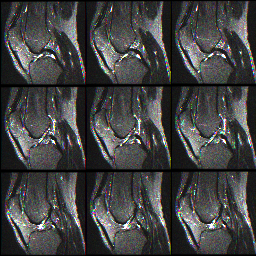

In [ ]:
sagittal_mensicus_val[5]


In [ ]:
sagittal_mensicus_val.view

<function ndarray.view>

In [ ]:
from keras.utils import to_categorical  # Import to_categorical
base_path = "/content/drive/My Drive/miniscus data set/MRNet-v1.0/"
X_train, Y_train, X_valid, Y_valid = np.concatenate((coronal_mensicus, sagittal_mensicus), axis=0), coronal_mensicus_label + sagittal_mensicus_label , np.concatenate((coronal_mensicus_val, sagittal_mensicus_val), axis=0),coronal_mensicus_label_val + sagittal_mensicus_label_val
num_classes =2
Y_train = to_categorical(Y_train, num_classes)
Y_valid = to_categorical(Y_valid, num_classes)
print(coronal_mensicus.shape, sagittal_mensicus.shape)
print(len(coronal_mensicus_label), len(sagittal_mensicus_label))
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)

(1130, 256, 256, 3) (1130, 256, 256, 3)
1130 1130
(2260, 256, 256, 3) (2260, 2) (240, 256, 256, 3) (240, 2)


#  Hyperparameters

In [ ]:
!pip install pandas openpyxl tensorflow

In [ ]:

from sklearn.metrics import log_loss
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Transfer Learning

**Hyperparameters**

In [ ]:
    # Define your parameters
    img_rows, img_cols = 256, 256  # Adjust based on your actual image dimensions
    channel = 3  # Assuming grayscale images
    num_classes = 2  # Binary classification
    batch_size = 32
    nb_epoch = 50
    dropout = 0.5
    lr = 1e-5  # Learning rat

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda, BatchNormalization
from tensorflow.keras.optimizers import SGD, schedules
from tensorflow.keras.callbacks import ModelCheckpoint


def create_model1(input_shape, num_classes, dropout):
    # Load the pre-trained DenseNet121 model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    input_tensor = Input(shape=input_shape)
    x = base_model(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = tf.keras.layers.Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=input_tensor, outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

if __name__ == '__main__':
    # Assuming your data is loaded as xtrain, ytrain, xvalid, yvalid


    # Create the model
    input_shape = (img_rows, img_cols, channel)
    model = create_model1(input_shape, num_classes, dropout)

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Set up the checkpoint
    filepath = "bestmodel.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]


    # Train the model
    history = model.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=(X_valid, Y_valid),
                        callbacks=callbacks_list)

    # Make predictions
    predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

    # If you want to use log_loss, make sure to import it
    from sklearn.metrics import log_loss
    score = log_loss(Y_valid, predictions_valid)
    print(f"Log Loss: {score}")
    model.summary()

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.5531 - loss: 0.7931
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to bestmodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 61s 492ms/step - accuracy: 0.5531 - loss: 0.7931 - val_accuracy: 0.5375 - val_loss: 0.9043
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5565 - loss: 0.7750
Epoch 2: val_accuracy improved from 0.53750 to 0.55833, saving model to bestmodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.5567 - loss: 0.7749 - val_accuracy: 0.5583 - val_loss: 0.7776
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5885 - loss: 0.7465
Epoch 3: val_accuracy did not improve from 0.55833
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.5884 - loss: 0.7465 - val_accuracy: 0.5458 - val_loss: 0.7475
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5997 - loss: 0.7369
Epoch 4: val_accuracy did not improve from 0.55833
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90m

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,146,950 (34.89 MB)

 Trainable params: 1,053,698 (4.02 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

 Optimizer params: 1,053,700 (4.02 MB)

**Results**

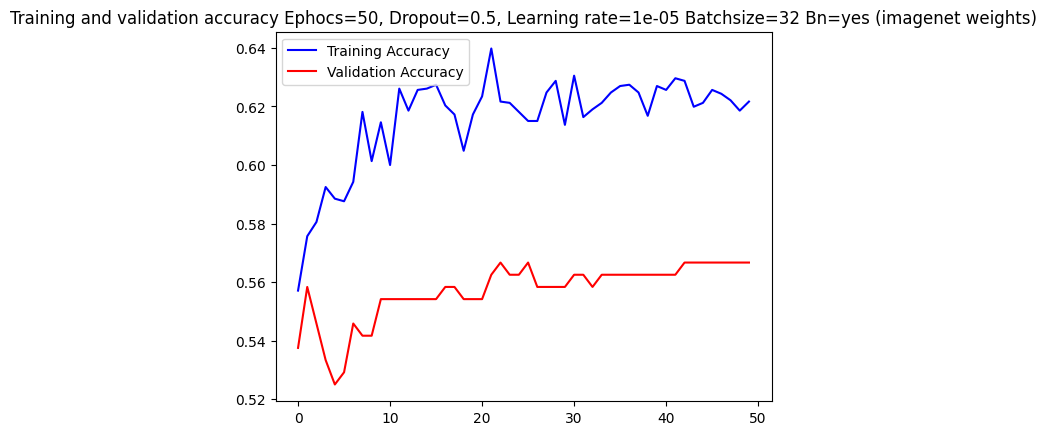

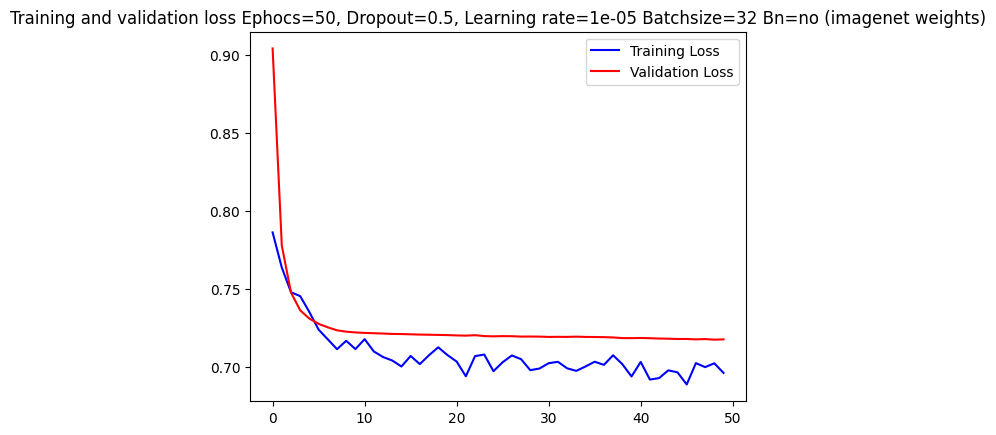

In [ ]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title(f'Training and validation accuracy Ephocs={nb_epoch}, Dropout={dropout}, Learning rate={lr} Batchsize={batch_size} Bn=yes (imagenet weights)')

plt.legend()
plt.savefig(f'Train_val_acc_Ep={nb_epoch}_Do={dropout}_Lr={lr}_Bs={batch_size}_Bn=no (imagenet weights).png')

plt.figure()


#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')

plt.title(f'Training and validation loss Ephocs={nb_epoch}, Dropout={dropout}, Learning rate={lr} Batchsize={batch_size} Bn=no (imagenet weights)')
plt.savefig(f'Train_val_loss_Ep={nb_epoch}_Do={dropout}_Lr={lr}_Bs={batch_size}_Bn=no (imagenet weights).png')

plt.legend()

plt.show()


In [ ]:
#X_valid, Y_valid
xtest=X_valid
ytest=Y_valid
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Total-test-data; 240 	accurately-predicted-data: 136 	 wrongly-predicted-data:  104
Accuracy: 56.667 %


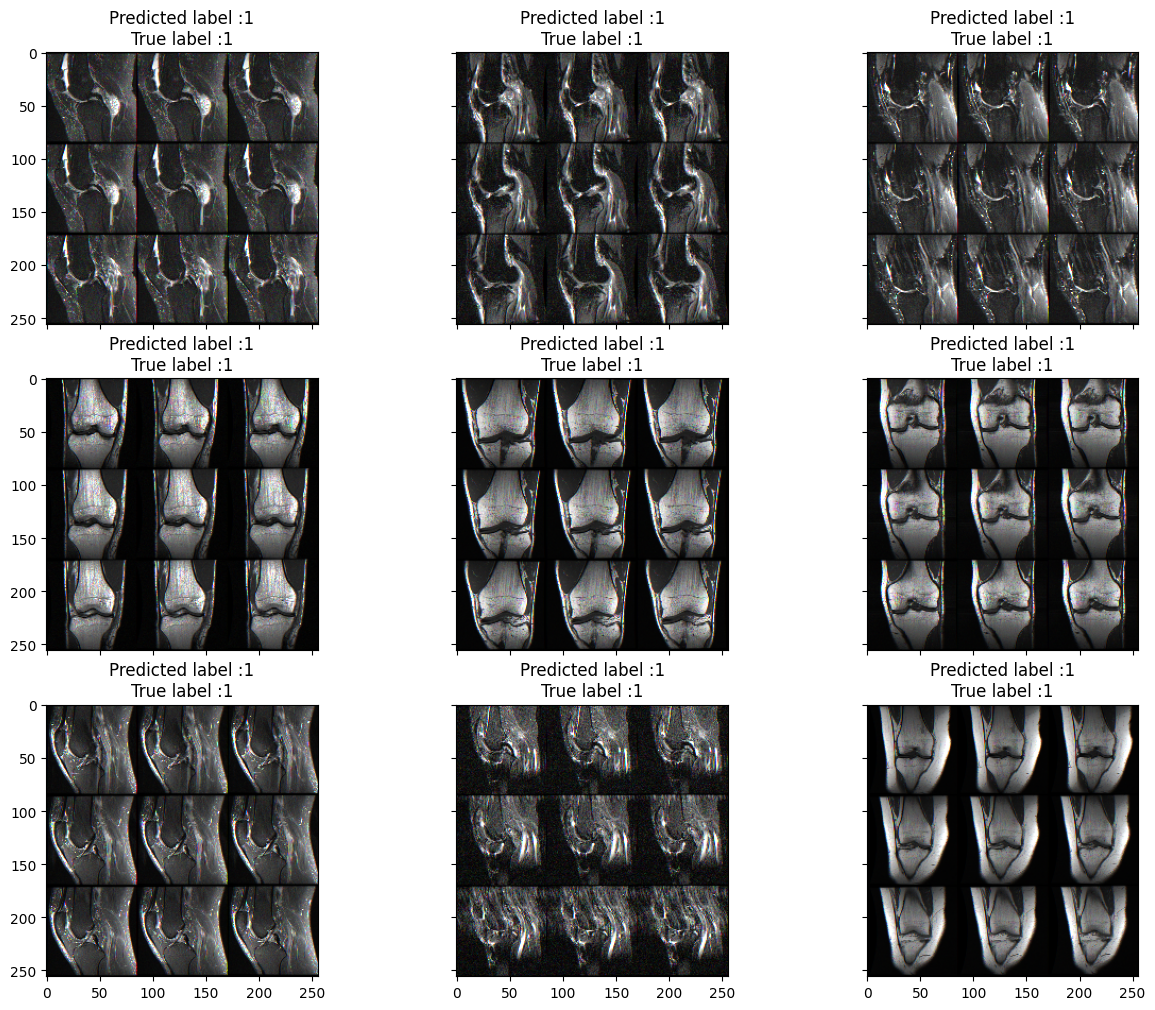

In [ ]:
label=['1', '0']
imidx = random.sample(accurateindex, k=9)

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row, col].imshow(xtest[imidx[n]], cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

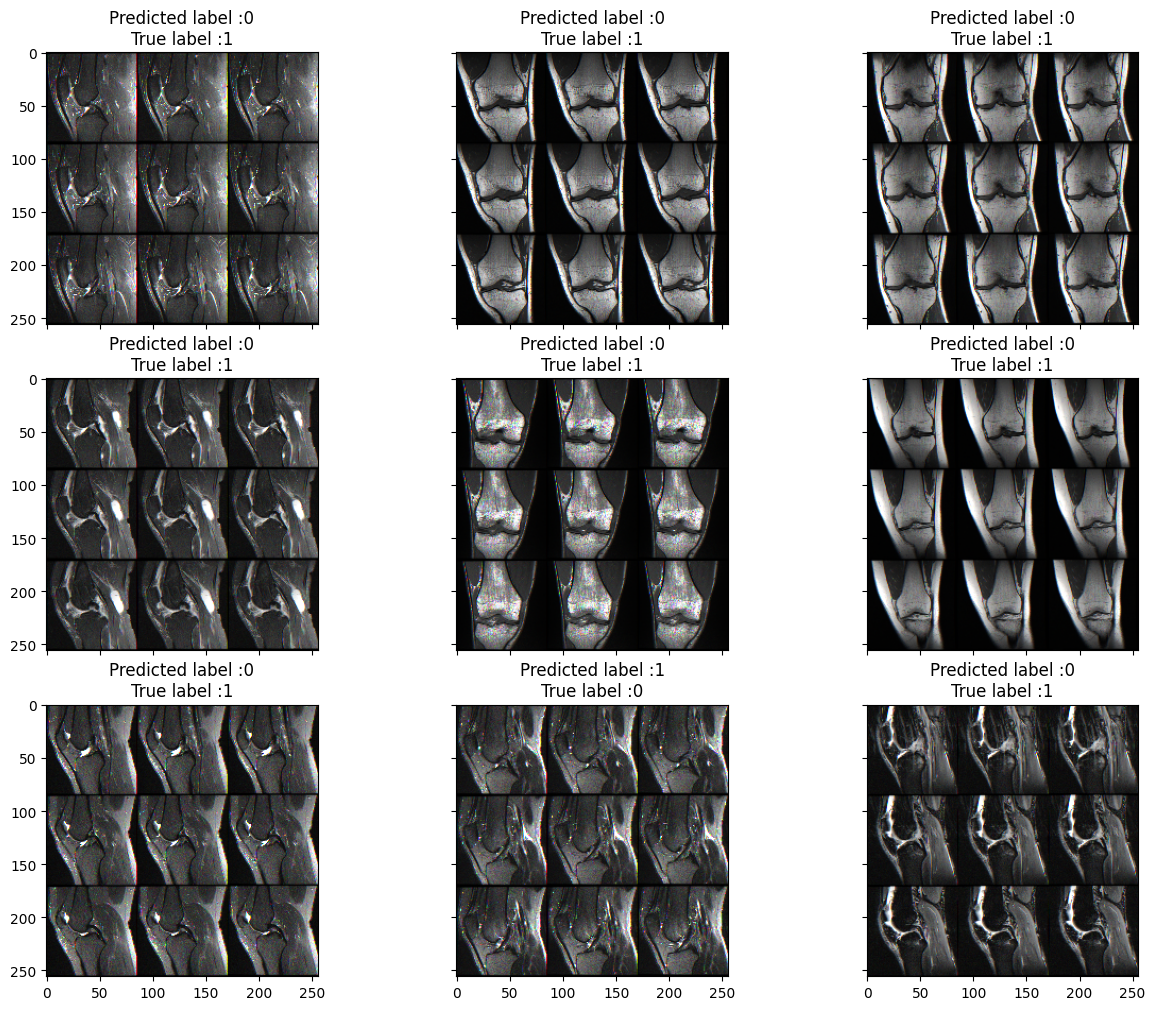

In [ ]:
label=['0', '1']
imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row, col].imshow(xtest[imidx[n]], cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()